In [123]:
%run './model/multi_corpus.py'
%run './constants.py'

from matplotlib import cm


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import umap.umap_ as umap

import functools

from scipy.spatial.distance import pdist, squareform

import itertools

In [2]:
corpora = citation_graphs()
Gs = {field_name: corpus['G'] for (field_name, corpus) in corpora.items()}
Dfs = {field_name: corpus['Df'] for (field_name, corpus) in corpora.items()}

Gender Studies DiGraph with 2224 nodes and 4332 edges
Geometry DiGraph with 2314 nodes and 2995 edges
Geophysics DiGraph with 38952 nodes and 162177 edges
Economics DiGraph with 7147 nodes and 55537 edges
Language & Linguistics DiGraph with 3128 nodes and 13572 edges
Probability & Statistics DiGraph with 5496 nodes and 19273 edges
Material Engineering DiGraph with 39045 nodes and 253189 edges
Artificial Intelligence DiGraph with 5475 nodes and 21705 edges
Sociology DiGraph with 4083 nodes and 25676 edges
International Business DiGraph with 5254 nodes and 36786 edges
Political Science DiGraph with 5305 nodes and 26335 edges
Genetics & Genomics DiGraph with 26776 nodes and 109991 edges
Immunology DiGraph with 27301 nodes and 195148 edges
Human Resources & Organizations DiGraph with 5848 nodes and 34965 edges
Ethnic & Cultural Studies DiGraph with 2105 nodes and 4041 edges
Neurology DiGraph with 32881 nodes and 282230 edges


In [70]:
def vectorization_method(method, texts):
    match method:
        case 'tfidf':
            tfidf = TfidfVectorizer()
            vecs = tfidf.fit_transform(texts.to_list()).toarray()
        case 'doc2vec':
            documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(texts.str.split(' ').to_list())]
            model = Doc2Vec(documents, vector_size=100, window=2, min_count=1, workers=4)
            vecs = np.array([model.dv[i] for i in range(len(texts))])
    return vecs

def format_field_name(field_name):
    if ' & ' in field_name:
        return ' &\n'.join(field_name.split(' & '))
    elif ' ' in field_name:
        return '\n'.join(field_name.split(' '))
    else:
        return field_name

In [72]:
n = 5_000

df_fields = []
for field_name, df in Dfs.items():

    G = Gs[field_name]
    in_deg = G.in_degree()
    sorted_in_deg = sorted(in_deg, key=lambda tup: tup[1])
    top_in_deg = [doi for doi, _ in sorted_in_deg][:n]

    df_fields.append(
        df
        .filter(pl.col('Doi').is_in(top_in_deg))
        .select(
            pl.col('Doi'),
            pl.col('Text').arr.join(' '),
            pl.lit(field_name).alias('Field'),
        )
    )
df_fields = pl.concat(df_fields)

print(df_fields.shape)

texts = df_fields['Text'].to_numpy()
fields = df_fields['Field'].to_numpy()

tfidf = TfidfVectorizer(stop_words='english')
tfidf_embedding = tfidf.fit_transform(texts)

reducer = umap.UMAP(random_state=42)
embs = reducer.fit_transform(tfidf_embedding)

df_fields = (
    df_fields
    .with_columns(pl.Series('Embedding', embs))
    .with_columns(
        pl.col('Embedding').arr.first().alias('x'),
        pl.col('Embedding').arr.last().alias('y'),
    )
)

print(df_fields.shape)

centroids = (
    df_fields
    .groupby('Field')
    .agg(
        pl.col('x').mean(),
        pl.col('y').mean(),
    )
)

print(centroids.shape)

(68865, 6)
(16, 3)


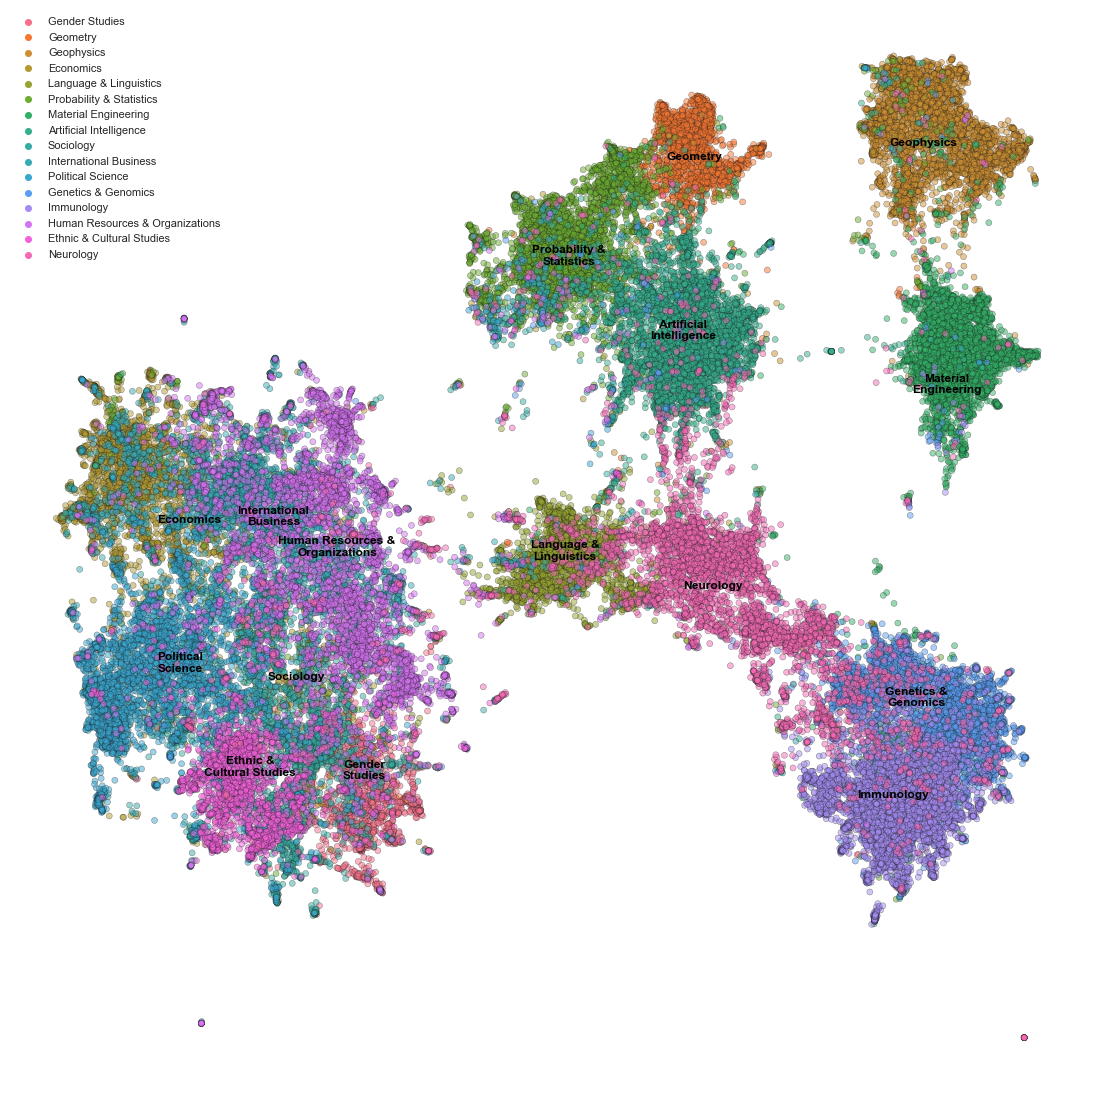

In [78]:

sns.set_theme(style='white')

fig = plt.figure(figsize=(15, 15))
ax = fig.add_axes([0, 0, 1, 1])

g = sns.scatterplot(data=df_fields, x="x", y="y", hue="Field", alpha=0.5, edgecolor='k') # , palette="deep", edgecolor='none'

for (field_name, x, y) in centroids.rows():
    field_name = format_field_name(field_name)
    plt.text(x, y, field_name, horizontalalignment='center', size='medium', color='black', weight='semibold')


sns.despine(bottom = True, left = True)
g.set(xlabel=None, ylabel=None, xticklabels=[], yticklabels=[])
plt.legend(frameon=False)

plt.savefig(
    os.path.join(LATEX_FIGURES_PATH, 'all_tfidf_umap.png'), 
    transparent=True, 
    dpi=300,
    bbox_inches='tight'
)

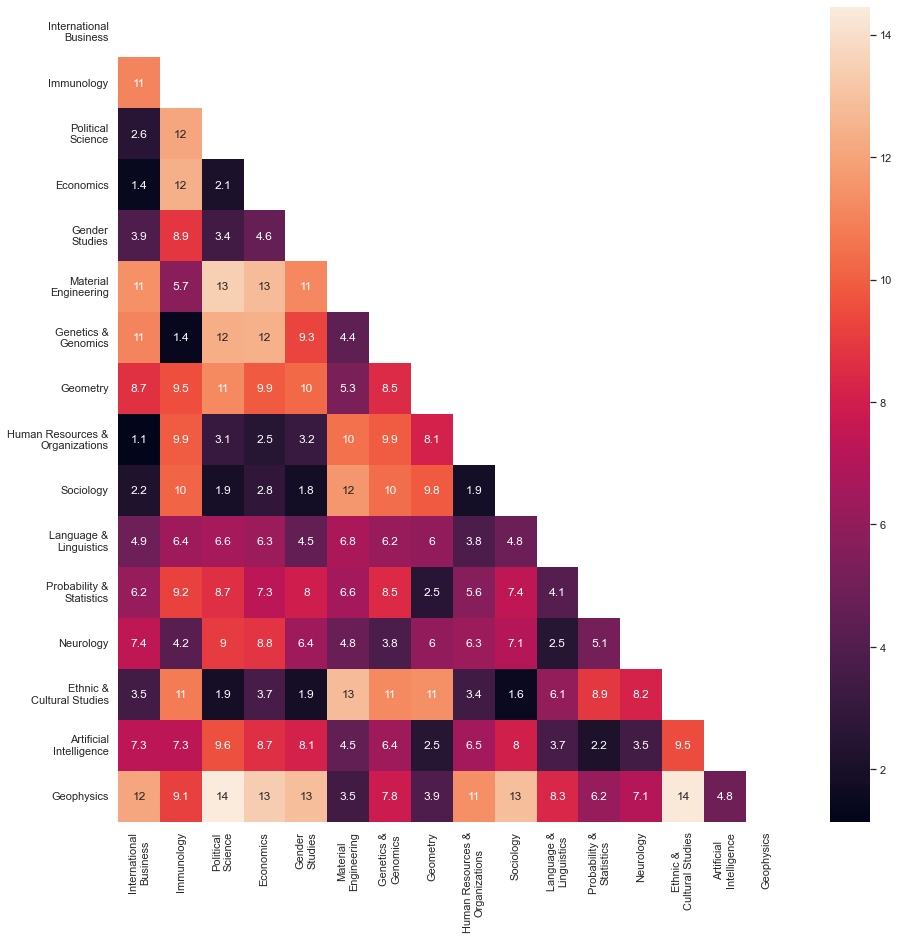

In [77]:
coords = centroids.select(['x', 'y']).to_numpy()

distances = np.round(squareform(pdist(coords)), 2)

dist_df = pl.from_numpy(distances)

mask = np.triu(np.ones_like(dist_df))

labels = [format_field_name(field_name) for field_name in centroids['Field']]

plt.figure(figsize=(15,15))
sns.heatmap(dist_df, annot=True, xticklabels=labels, yticklabels=labels, mask=mask)

plt.savefig(
    os.path.join(LATEX_FIGURES_PATH, 'all_tfidf_umap_distance_heatmap.png'), 
    transparent=True, 
    dpi=300,
    bbox_inches='tight'
)

# Desc Stats

In [165]:
corpora = citation_graphs()
Gs_citation = {field_name: corpus['G'] for (field_name, corpus) in corpora.items()}

corpora = co_citation_graphs()
Gs_co_citation = {field_name: corpus['G'] for (field_name, corpus) in corpora.items()}

corpora = co_occurence_graphs()
Gs_co_occurrence = {field_name: corpus['G'] for (field_name, corpus) in corpora.items()}

Gender Studies DiGraph with 2224 nodes and 4332 edges
Geometry DiGraph with 2314 nodes and 2995 edges
Geophysics DiGraph with 38952 nodes and 162177 edges
Economics DiGraph with 7147 nodes and 55537 edges
Language & Linguistics DiGraph with 3128 nodes and 13572 edges
Probability & Statistics DiGraph with 5496 nodes and 19273 edges
Material Engineering DiGraph with 39045 nodes and 253189 edges
Artificial Intelligence DiGraph with 5475 nodes and 21705 edges
Sociology DiGraph with 4083 nodes and 25676 edges
International Business DiGraph with 5254 nodes and 36786 edges
Political Science DiGraph with 5305 nodes and 26335 edges
Genetics & Genomics DiGraph with 26776 nodes and 109991 edges
Immunology DiGraph with 27301 nodes and 195148 edges
Human Resources & Organizations DiGraph with 5848 nodes and 34965 edges
Ethnic & Cultural Studies DiGraph with 2105 nodes and 4041 edges
Neurology DiGraph with 32881 nodes and 282230 edges
Gender Studies Graph with 439 nodes and 810 edges
Geometry Graph 

In [231]:
import pandas as pd

fields = []
nodes = []
edges = []
for field_name, G in Gs_citation.items():
    fields.append(field_name)
    nodes.append(nx.number_of_nodes(G))
    edges.append(nx.number_of_edges(G))

df_citation_desc = pd.DataFrame({
    ("", "Field"): fields,
    ("Citation", "Nodes"): nodes,
    ("Citation", "Edges"): edges,
})

fields = []
nodes = []
edges = []
for field_name, G in Gs_co_citation.items():
    fields.append(field_name)
    nodes.append(nx.number_of_nodes(G))
    edges.append(nx.number_of_edges(G))

df_co_citation_desc = pd.DataFrame({
    ("", "Field"): fields,
    ("Co-Citation", "Nodes"): nodes,
    ("Co-Citation", "Edges"): edges,
})

fields = []
nodes = []
edges = []
for field_name, G in Gs_co_occurrence.items():
    fields.append(field_name)
    nodes.append(nx.number_of_nodes(G))
    edges.append(nx.number_of_edges(G))

df_co_occurrence_desc = pd.DataFrame({
    ("", "Field"): fields,
    ("Co-Occurrence", "Nodes"): nodes,
    ("Co-Occurrence", "Edges"): edges,
})

# merged = pd.merge(dfs, on=[('', 'Field')])
# merged


import functools
dfs = [
    df_citation_desc,
    df_co_citation_desc,
    df_co_occurrence_desc,
]
df_final = functools.reduce(lambda left, right: pd.merge(left, right, on=[('', 'Field')]), dfs)
df_final

latex = df_final.to_latex(
    index=False,
    na_rep=' ',
    bold_rows=True,
    float_format="%.2f",
)

with open(os.path.join(LATEX_TABLE_PATH, 'all_desc_stats.tex'), 'w+') as file:
    file.write(latex)

print(latex)

\begin{tabular}{lrrrrrr}
\toprule
                                & \multicolumn{2}{l}{Citation} & \multicolumn{2}{l}{Co-Citation} & \multicolumn{2}{l}{Co-Occurrence} \\
                          Field &    Nodes &  Edges &       Nodes &  Edges &         Nodes &   Edges \\
\midrule
                 Gender Studies &     2224 &   4332 &         439 &    810 &         18375 & 2362724 \\
                       Geometry &     2314 &   2995 &         298 &    388 &         11881 & 1119429 \\
                     Geophysics &    38952 & 162177 &       16305 &  82952 &         21341 & 3709723 \\
                      Economics &     7147 &  55537 &        4278 &  53161 &         12780 & 1347658 \\
         Language \& Linguistics &     3128 &  13572 &        1270 &   7819 &         14771 & 1955723 \\
       Probability \& Statistics &     5496 &  19273 &        1805 &   8151 &         15127 & 2272474 \\
           Material Engineering &    39045 & 253189 &       19577 & 213117 &         20958 

/var/folders/rz/n4jmlyh1355cy_wkn5gd00x40000gn/T/ipykernel_89206/2055111324.py:58: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = df_final.to_latex(


# Clusters




In [ ]:
corpora = citation_graphs()
Gs_citation = {field_name: corpus['G'] for (field_name, corpus) in corpora.items()}

corpora = co_citation_graphs()
Gs_co_citation = {field_name: corpus['G'] for (field_name, corpus) in corpora.items()}

corpora = co_occurence_graphs()
Gs_co_occurrence = {field_name: corpus['G'] for (field_name, corpus) in corpora.items()}

Gender Studies DiGraph with 2224 nodes and 4332 edges
Geometry DiGraph with 2314 nodes and 2995 edges
Geophysics DiGraph with 38952 nodes and 162177 edges
Economics DiGraph with 7147 nodes and 55537 edges
Language & Linguistics DiGraph with 3128 nodes and 13572 edges
Probability & Statistics DiGraph with 5496 nodes and 19273 edges
Material Engineering DiGraph with 39045 nodes and 253189 edges
Artificial Intelligence DiGraph with 5475 nodes and 21705 edges
Sociology DiGraph with 4083 nodes and 25676 edges
International Business DiGraph with 5254 nodes and 36786 edges
Political Science DiGraph with 5305 nodes and 26335 edges
Genetics & Genomics DiGraph with 26776 nodes and 109991 edges
Immunology DiGraph with 27301 nodes and 195148 edges
Human Resources & Organizations DiGraph with 5848 nodes and 34965 edges
Ethnic & Cultural Studies DiGraph with 2105 nodes and 4041 edges
Neurology DiGraph with 32881 nodes and 282230 edges
Gender Studies Graph with 439 nodes and 810 edges
Geometry Graph 

In [ ]:
communities = {}
for field_name, G in Gs_citation.items():
    print(field_name)
    communities[field_name] = nx.community.louvain_communities(G)

citation_comms = {field_name: len(comms) for field_name, comms in communities.items()}

df_citation_comms = pl.DataFrame({
    "Field": list(citation_comms.keys()),
    "Citation": list(citation_comms.values()),
})

communities = {}
for field_name, G in Gs_co_citation.items():
    print(field_name)
    communities[field_name] = nx.community.louvain_communities(G)

co_citation_comms = {field_name: len(comms) for field_name, comms in communities.items()}

df_co_citation_comms = pl.DataFrame({
    "Field": list(co_citation_comms.keys()),
    "Co-Citation": list(co_citation_comms.values()),
})

communities = {}
for field_name, G in Gs_co_occurrence.items():
    print(field_name)
    communities[field_name] = nx.community.louvain_communities(G)

co_occurrence_comms = {field_name: len(comms) for field_name, comms in communities.items()}

df_co_occurrence_comms = pl.DataFrame({
    "Field": list(co_occurrence_comms.keys()),
    "Co-Occurrence": list(co_occurrence_comms.values()),
})

dfs = [df_citation_comms, df_co_citation_comms, df_co_occurrence_comms]

df_final = functools.reduce(lambda left, right: left.join(right, on='Field'), dfs)

Gender Studies
Geometry
Geophysics
Economics
Language & Linguistics
Probability & Statistics
Material Engineering
Artificial Intelligence
Sociology
International Business
Political Science
Genetics & Genomics
Immunology
Human Resources & Organizations
Ethnic & Cultural Studies
Neurology


{'Gender Studies': 558,
 'Geometry': 715,
 'Geophysics': 5133,
 'Economics': 417,
 'Language & Linguistics': 364,
 'Probability & Statistics': 933,
 'Material Engineering': 2175,
 'Artificial Intelligence': 668,
 'Sociology': 262,
 'International Business': 319,
 'Political Science': 520,
 'Genetics & Genomics': 4312,
 'Immunology': 1387,
 'Human Resources & Organizations': 395,
 'Ethnic & Cultural Studies': 607,
 'Neurology': 1047}

In [15]:
latex = df_final.to_pandas().to_latex(index=False, bold_rows=True)

with open(os.path.join(LATEX_TABLE_PATH, 'all_louvain_communities.tex'), 'w+') as file:
    file.write(latex)

print(latex)

\begin{tabular}{lrrr}
\toprule
                          Field &  Citation &  Co-Citation &  Co-Occurrence \\
\midrule
                 Gender Studies &       566 &           54 &              6 \\
                       Geometry &       726 &           73 &              7 \\
                     Geophysics &      5307 &          436 &              5 \\
                      Economics &       415 &           33 &              6 \\
         Language \& Linguistics &       345 &           34 &              6 \\
       Probability \& Statistics &       928 &          102 &              4 \\
           Material Engineering &      2530 &          212 &              5 \\
        Artificial Intelligence &       689 &           44 &              8 \\
                      Sociology &       270 &           26 &              7 \\
         International Business &       322 &           39 &              6 \\
              Political Science &       522 &           47 &              7 \\
          

/var/folders/rz/n4jmlyh1355cy_wkn5gd00x40000gn/T/ipykernel_44220/372548584.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = df_final.to_pandas().to_latex(index=False, bold_rows=True)


In [17]:
(
    df_final
    .select(pl.exclude('Field'))
    .select(
        pl.pearson_corr('Citation', 'Co-Citation').alias('Citation Co-Citation'),
        pl.pearson_corr('Citation', 'Co-Occurrence').alias('Citation Co-Occurrence'),
        pl.pearson_corr('Co-Citation', 'Co-Occurrence').alias('Co-Citation Co-Occurrence'),
    )
)

Citation Co-Citation,Citation Co-Occurrence,Co-Citation Co-Occurrence
f64,f64,f64
0.993511,0.464224,0.458584


In [21]:
citation_comps = {}
for field_name, G in Gs_citation.items():
    print(field_name)
    citation_comps[field_name] = nx.number_weakly_connected_components(G)

df_citation_comps = pl.DataFrame({
    "Field": list(citation_comps.keys()),
    "Citation": list(citation_comps.values()),
})

co_citation_comps = {}
for field_name, G in Gs_co_citation.items():
    print(field_name)
    co_citation_comps[field_name] = nx.number_connected_components(G)

df_co_citation_comps = pl.DataFrame({
    "Field": list(co_citation_comps.keys()),
    "Co-Citation": list(co_citation_comps.values()),
})

co_occurrence_comps = {}
for field_name, G in Gs_co_occurrence.items():
    print(field_name)
    co_occurrence_comps[field_name] = nx.number_connected_components(G)

df_co_occurrence_comps = pl.DataFrame({
    "Field": list(co_occurrence_comps.keys()),
    "Co-Occurrence": list(co_occurrence_comps.values()),
})

dfs = [df_citation_comps, df_co_citation_comps, df_co_occurrence_comps]

df_final = functools.reduce(lambda left, right: left.join(right, on='Field'), dfs)

Gender Studies
Geometry
Geophysics
Economics
Language & Linguistics
Probability & Statistics
Material Engineering
Artificial Intelligence
Sociology
International Business
Political Science
Genetics & Genomics
Immunology
Human Resources & Organizations
Ethnic & Cultural Studies
Neurology
Gender Studies
Geometry
Geophysics
Economics
Language & Linguistics
Probability & Statistics
Material Engineering
Artificial Intelligence
Sociology
International Business
Political Science
Genetics & Genomics
Immunology
Human Resources & Organizations
Ethnic & Cultural Studies
Neurology
Gender Studies
Geometry
Geophysics
Economics
Language & Linguistics
Probability & Statistics
Material Engineering
Artificial Intelligence
Sociology
International Business
Political Science
Genetics & Genomics
Immunology
Human Resources & Organizations
Ethnic & Cultural Studies
Neurology


In [22]:
latex = df_final.to_pandas().to_latex(index=False, bold_rows=True)

with open(os.path.join(LATEX_TABLE_PATH, 'all_components.tex'), 'w+') as file:
    file.write(latex)

print(latex)

\begin{tabular}{lrrr}
\toprule
                          Field &  Citation &  Co-Citation &  Co-Occurrence \\
\midrule
                 Gender Studies &        48 &           43 &              1 \\
                       Geometry &       299 &           70 &              1 \\
                     Geophysics &       163 &          387 &              1 \\
                      Economics &         4 &           20 &              1 \\
         Language \& Linguistics &        12 &           17 &              1 \\
       Probability \& Statistics &        92 &           77 &              1 \\
           Material Engineering &        50 &          179 &              1 \\
        Artificial Intelligence &        16 &           24 &              1 \\
                      Sociology &         8 &           15 &              1 \\
         International Business &        12 &           29 &              1 \\
              Political Science &        27 &           29 &              1 \\
          

/var/folders/rz/n4jmlyh1355cy_wkn5gd00x40000gn/T/ipykernel_79466/1866771792.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = df_final.to_pandas().to_latex(index=False, bold_rows=True)


# Groups

In [81]:
corpora = co_citation_graphs()
Gs = {field_name: corpus['G'] for (field_name, corpus) in corpora.items()}
Dfs = {field_name: corpus['Df'] for (field_name, corpus) in corpora.items()}

Gender Studies Graph with 439 nodes and 810 edges
Geometry Graph with 298 nodes and 388 edges
Geophysics Graph with 16305 nodes and 82952 edges
Economics Graph with 4278 nodes and 53161 edges
Language & Linguistics Graph with 1270 nodes and 7819 edges
Probability & Statistics Graph with 1805 nodes and 8151 edges
Material Engineering Graph with 19577 nodes and 213117 edges
Artificial Intelligence Graph with 1897 nodes and 9012 edges
Sociology Graph with 2327 nodes and 21230 edges
International Business Graph with 2667 nodes and 39483 edges
Political Science Graph with 2442 nodes and 13314 edges
Genetics & Genomics Graph with 9323 nodes and 55121 edges
Immunology Graph with 12636 nodes and 190468 edges
Human Resources & Organizations Graph with 3063 nodes and 24554 edges
Ethnic & Cultural Studies Graph with 310 nodes and 506 edges
Neurology Graph with 18589 nodes and 270528 edges


In [163]:
def avg_degree(G):
    degree = dict(G.degree()).values()
    return sum(degree) / len(degree)

def triangles(G):
    return sum(nx.triangles(G).values()) / 3

def gini(G):
    x = list(dict(G.degree()).values())
    mad = np.abs(np.subtract.outer(x, x)).mean()
    rmad = mad/np.mean(x)
    gini = 0.5 * rmad
    return gini

def louvain_communities(G):
    return len(nx.community.louvain_communities(G))

def components(G):
    return len(list(nx.connected_components(G)))

def centralization(G):
    degree = dict(G.degree()).values()
    return float((len(G) * max(degree) - sum(degree))) / (len(G)-1)**2

measurments = {
    # 'Nodes': nx.number_of_nodes,
    # 'Edges': nx.number_of_edges,
    'Density': nx.density,
    'AvgDegree': avg_degree,
    # 'DiameterLargestComponent': nx.diameter(G.subgraph(large_component)),
    # 'AvgShortestPath': nx.average_shortest_path_length(G_large_component),
    # 'ShortestPath': nx.shortest_path_length,
    'Triangles': triangles,
    # 'Gini': gini,
    'Louvain': louvain_communities,
    'Components': components,
    'AvgClustering': nx.average_clustering,
    'Transitivity': nx.transitivity,
    'Centralization': centralization,
    # 'Isolates': nx.number_of_isolates(G),
    # 'Loops': nx.number_of_selfloops(G),
    # 'LabelPropagation': len(nx_comm.label_propagation_communities(G)),
}

measurment_combs = list(itertools.combinations(measurments.keys(), 2))
print(len(measurment_combs))
print(list(measurments.keys()))

28
['Density', 'AvgDegree', 'Triangles', 'Louvain', 'Components', 'AvgClustering', 'Transitivity', 'Centralization']


Density - AvgDegree 

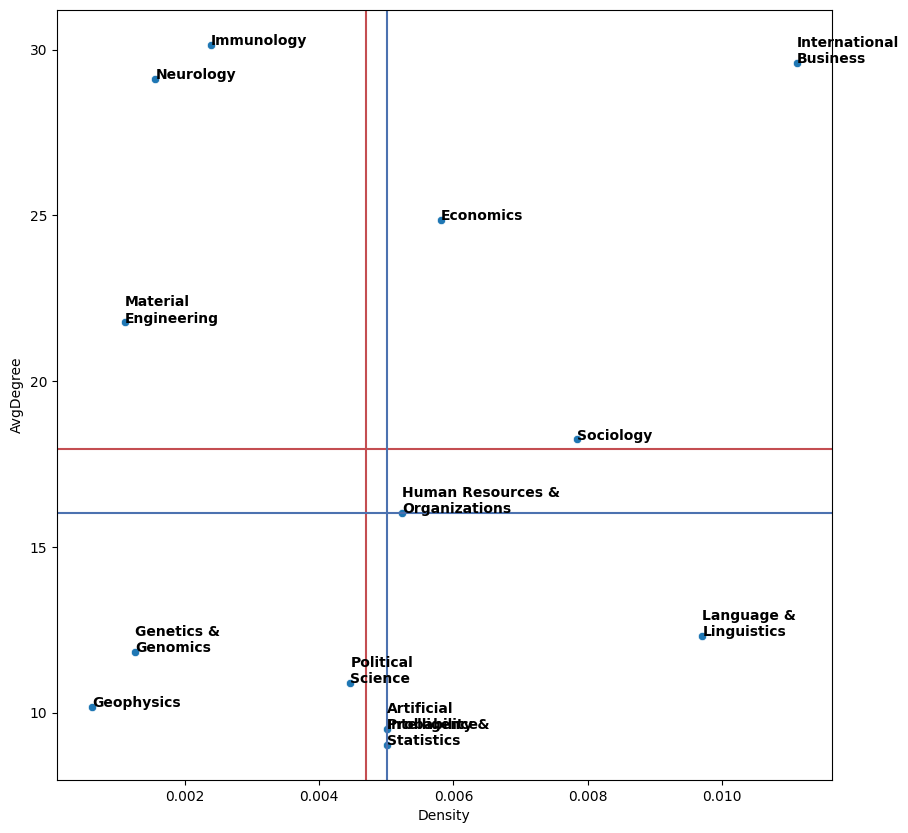

Density - Triangles 

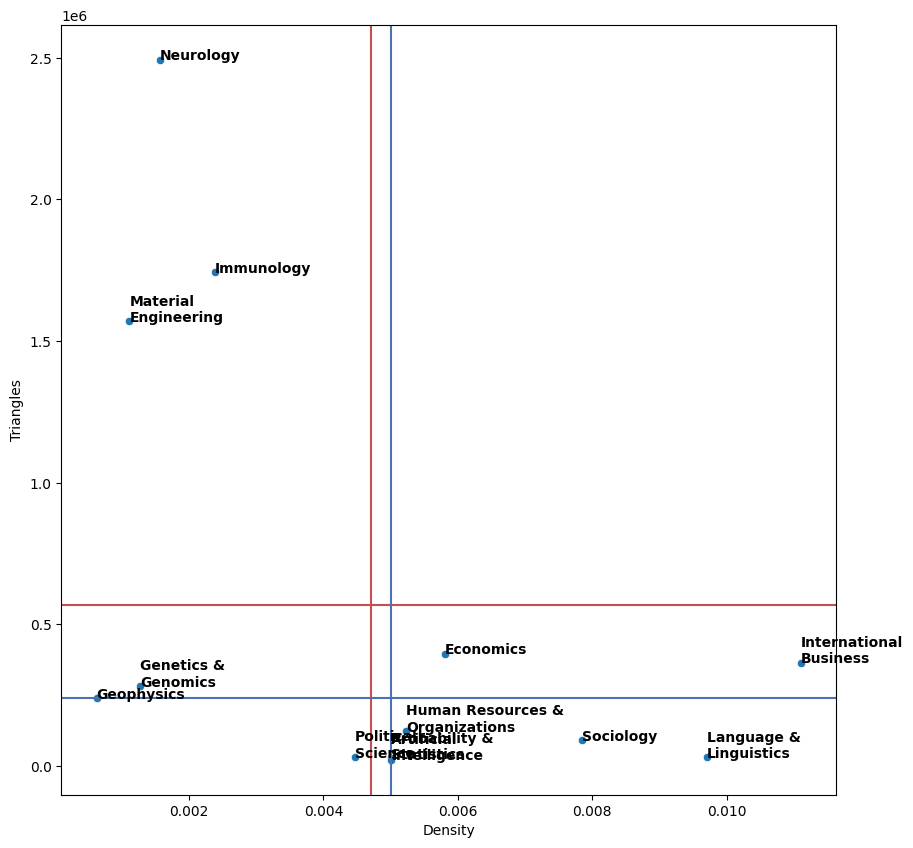

Density - Louvain 

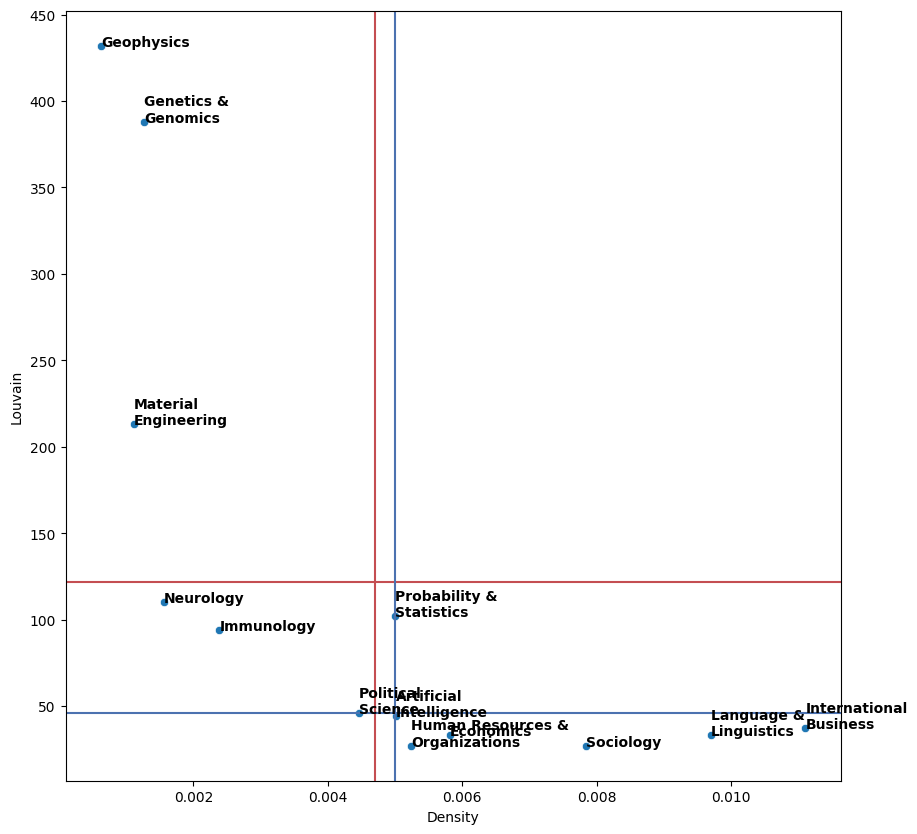

Density - Components 

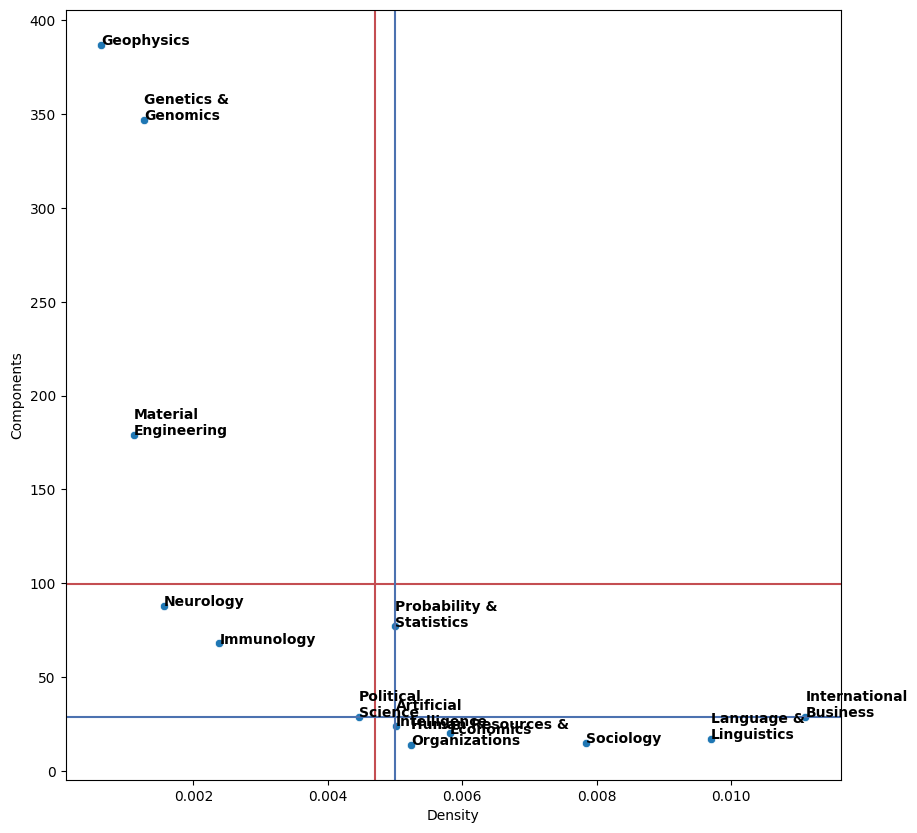

Density - AvgClustering 

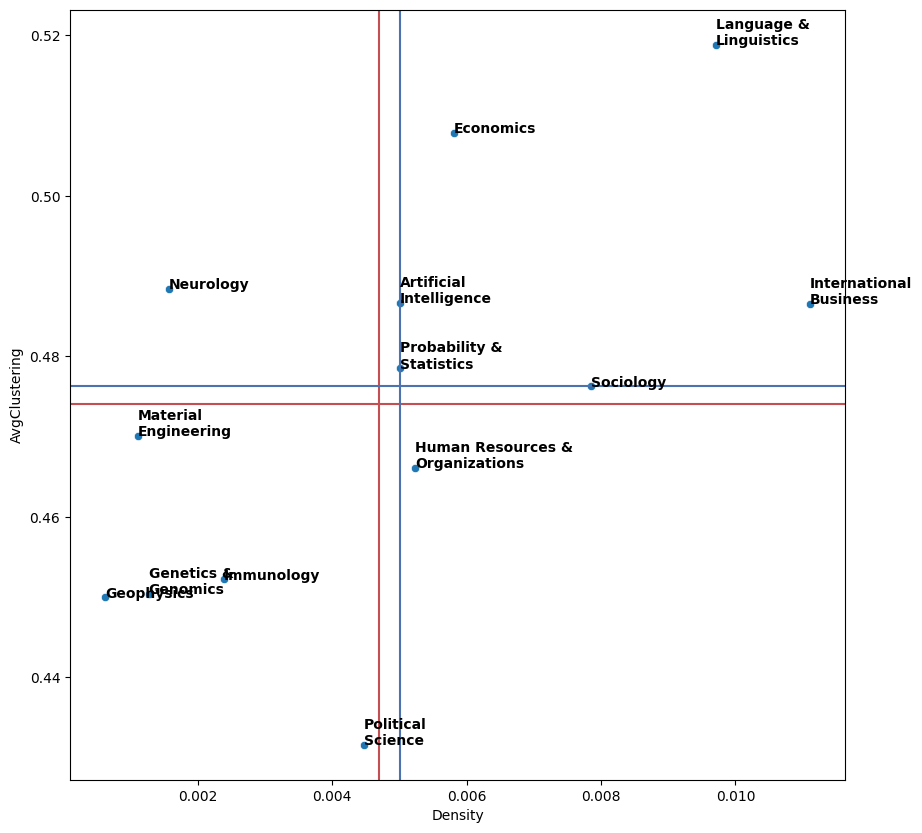

Density - Transitivity 

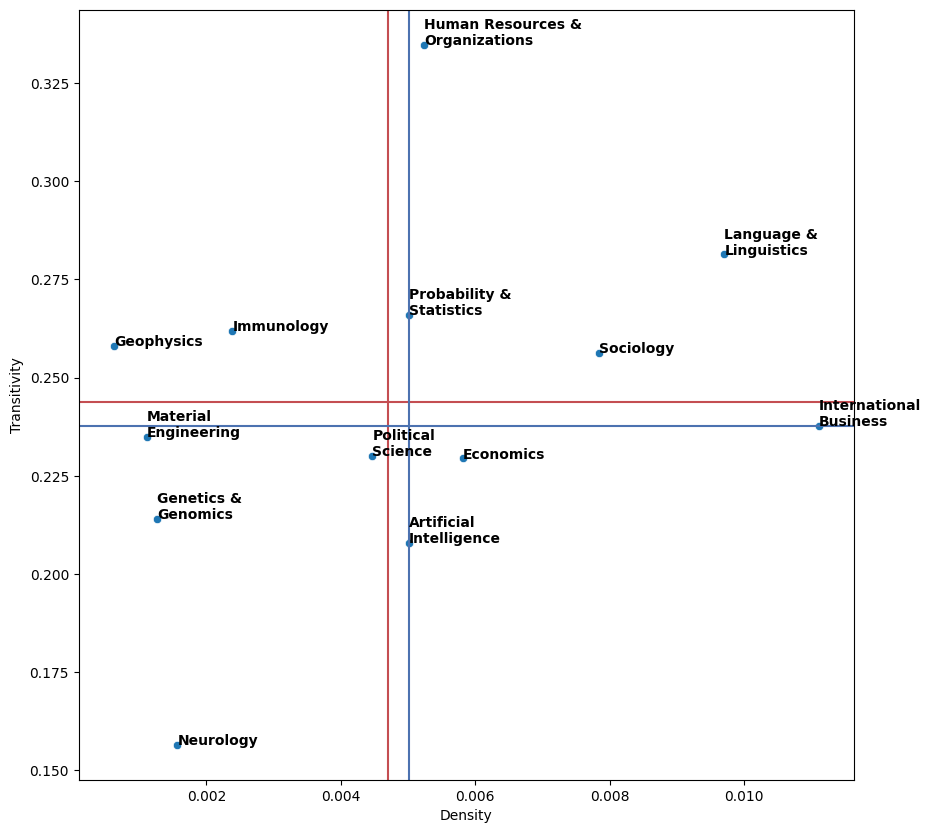

Density - Centralization 

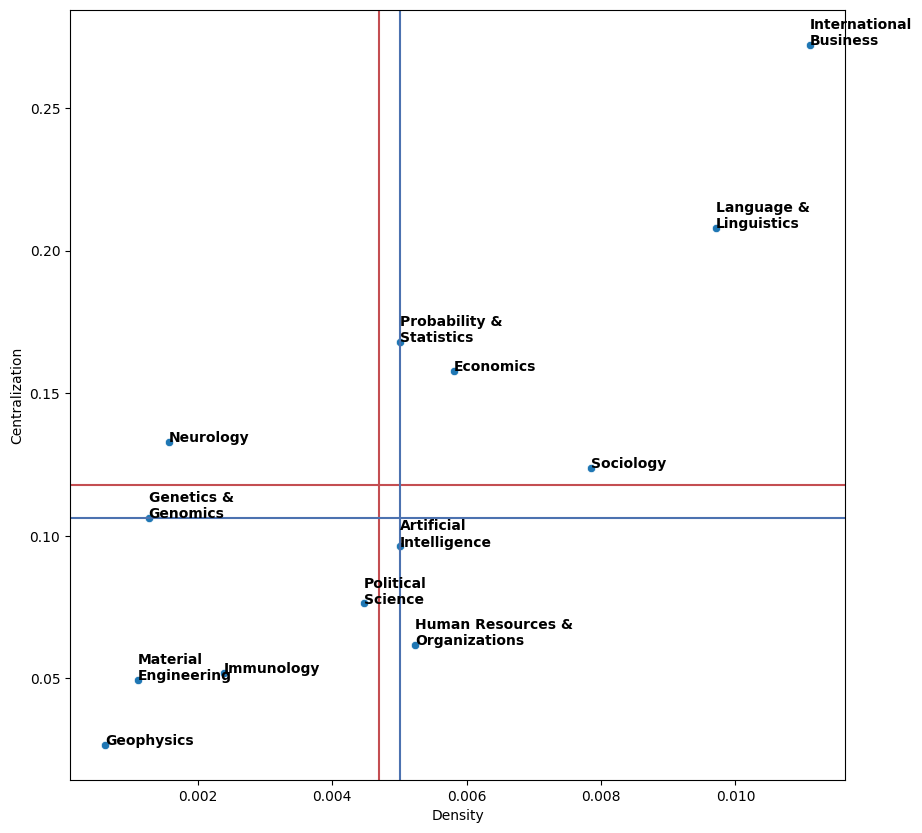

AvgDegree - Triangles 

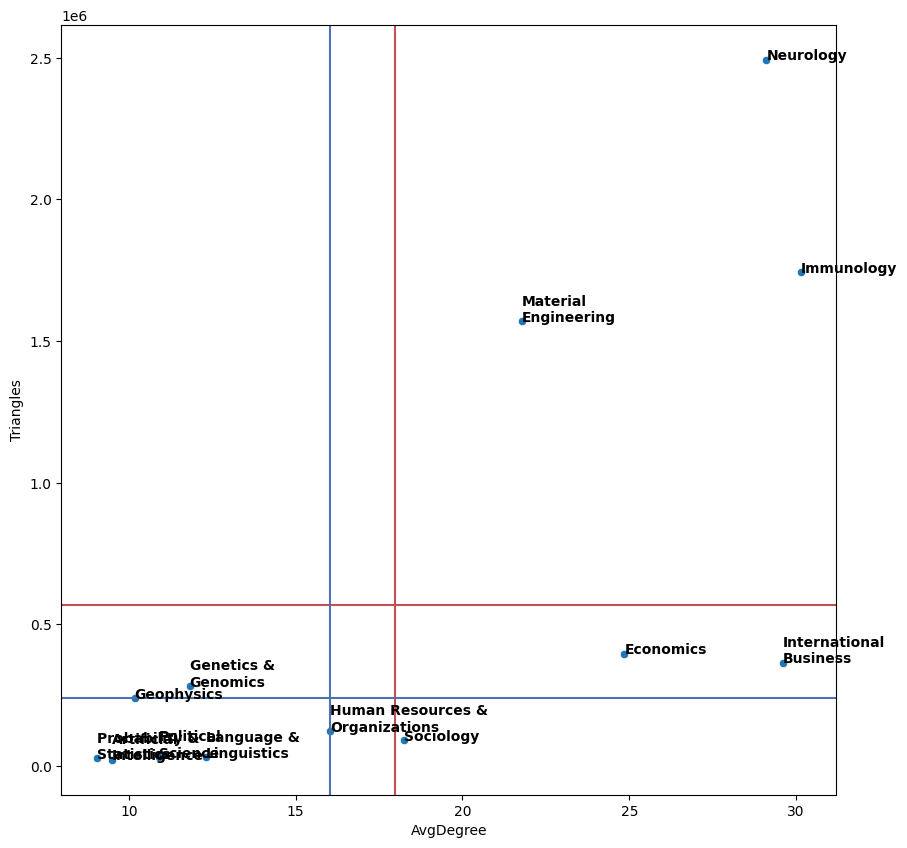

AvgDegree - Louvain 

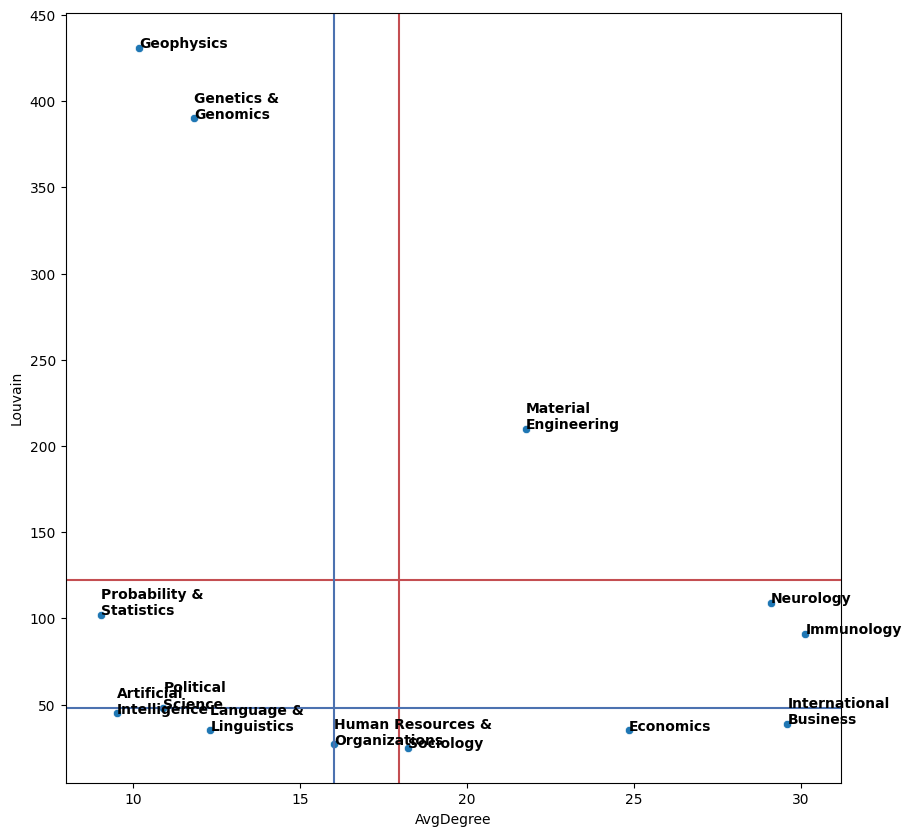

AvgDegree - Components 

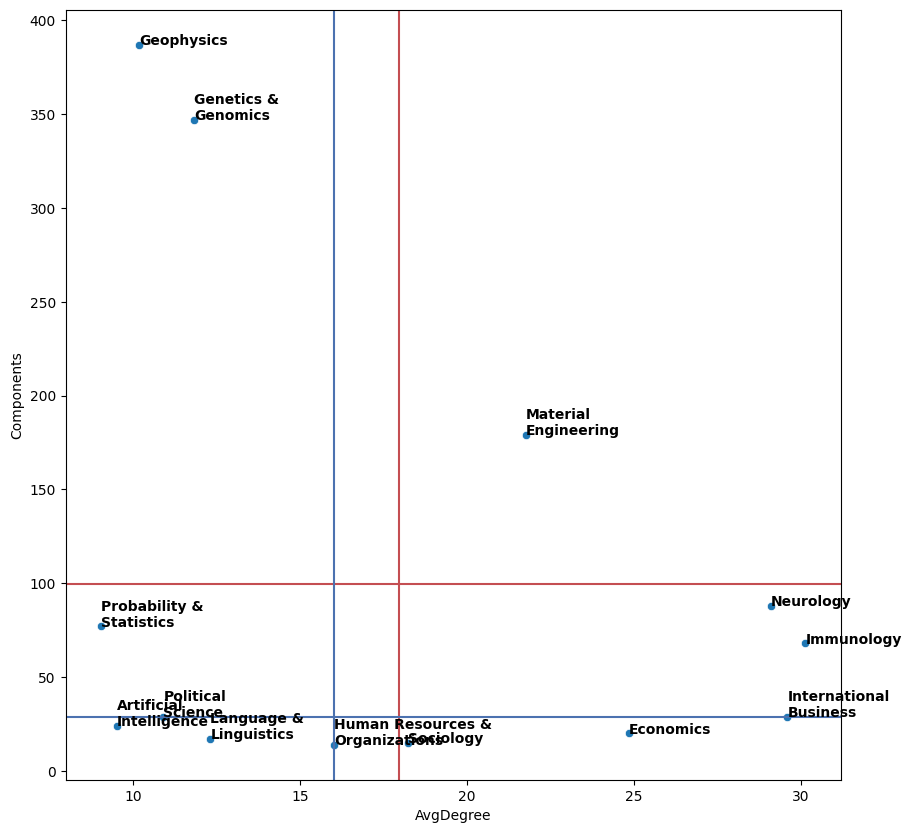

AvgDegree - AvgClustering 

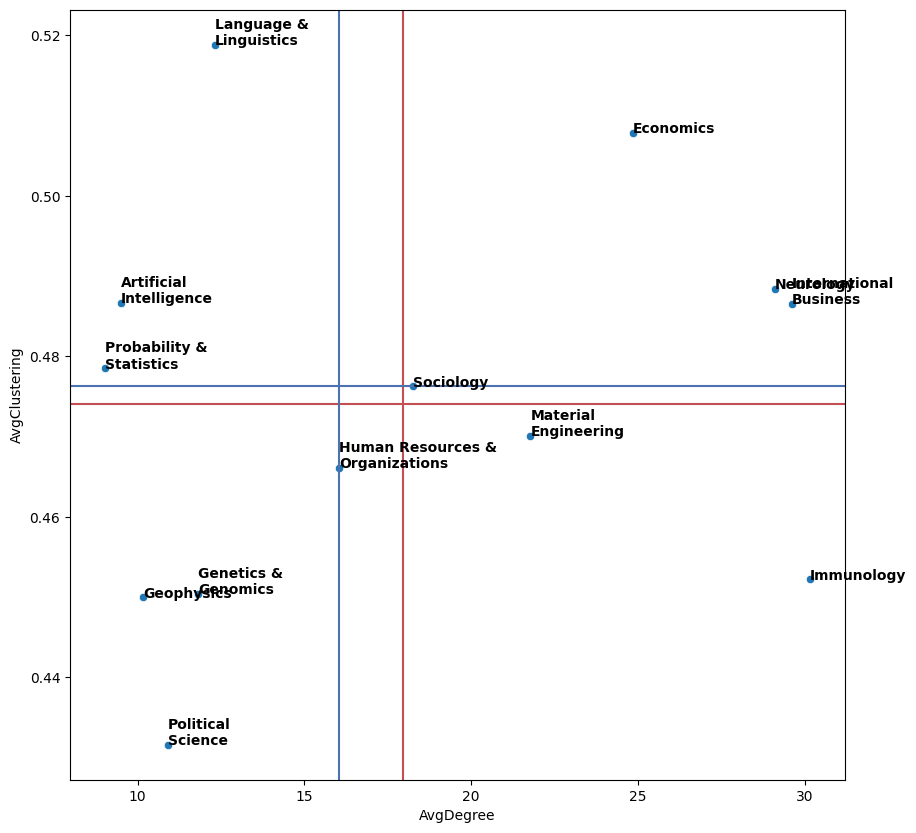

AvgDegree - Transitivity 

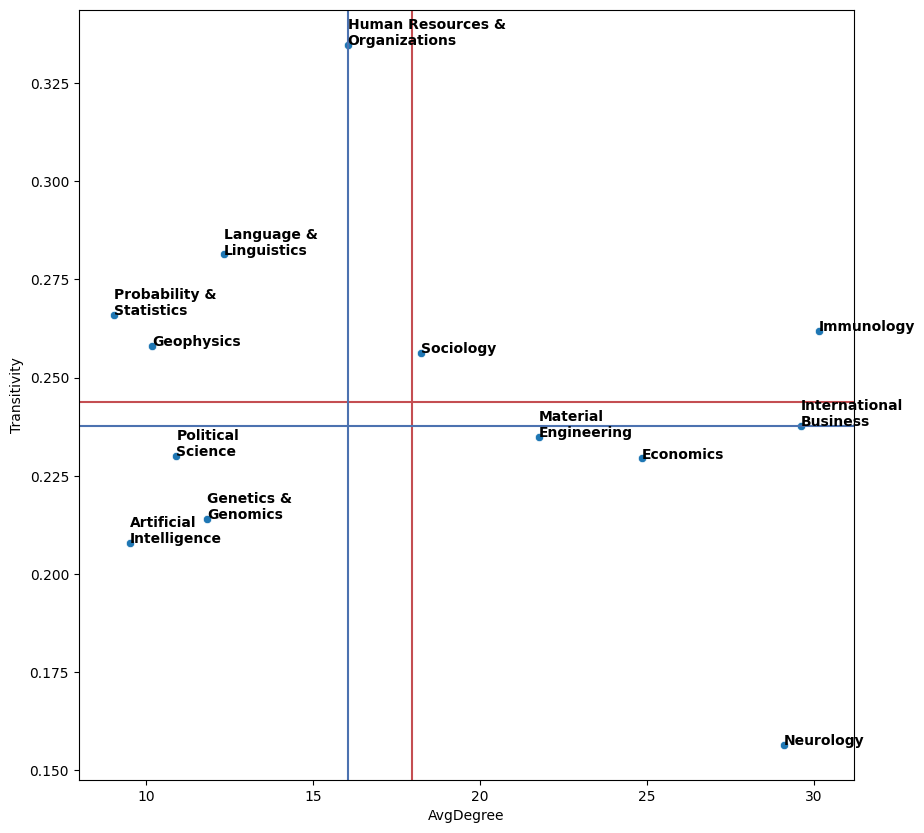

AvgDegree - Centralization 

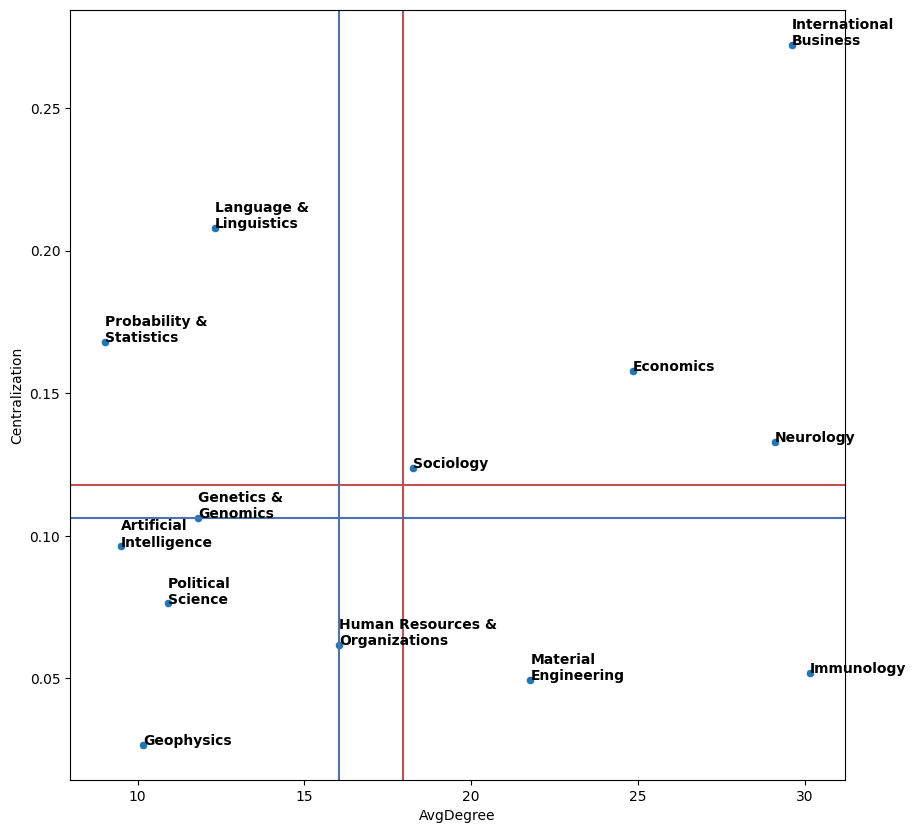

Triangles - Louvain 

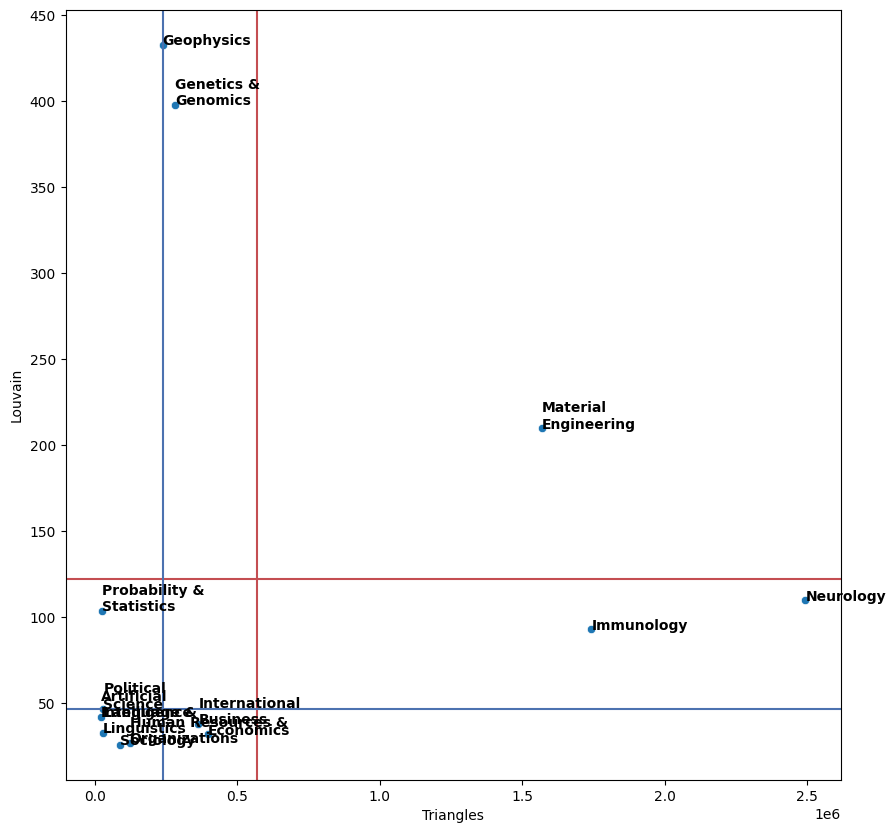

Triangles - Components 

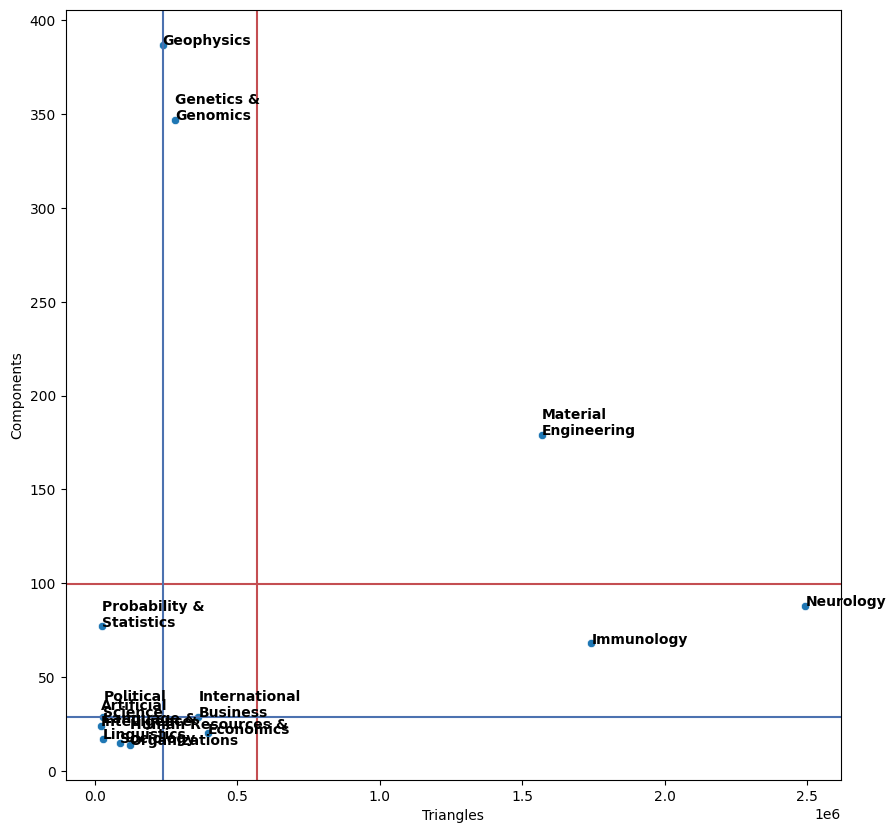

Triangles - AvgClustering 

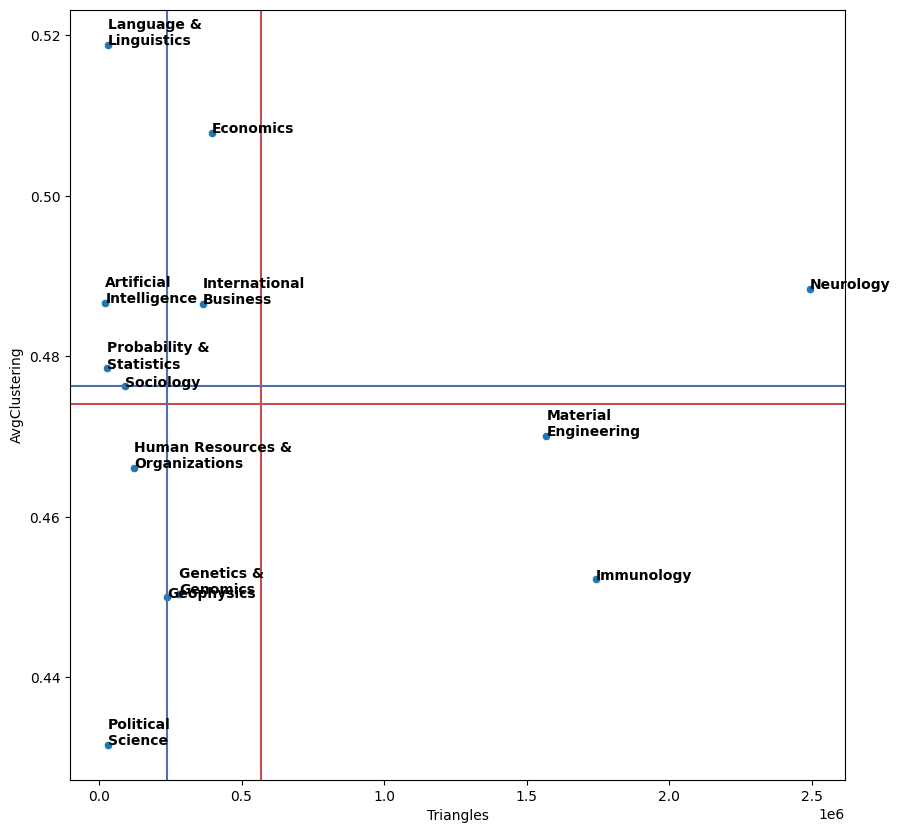

Triangles - Transitivity 

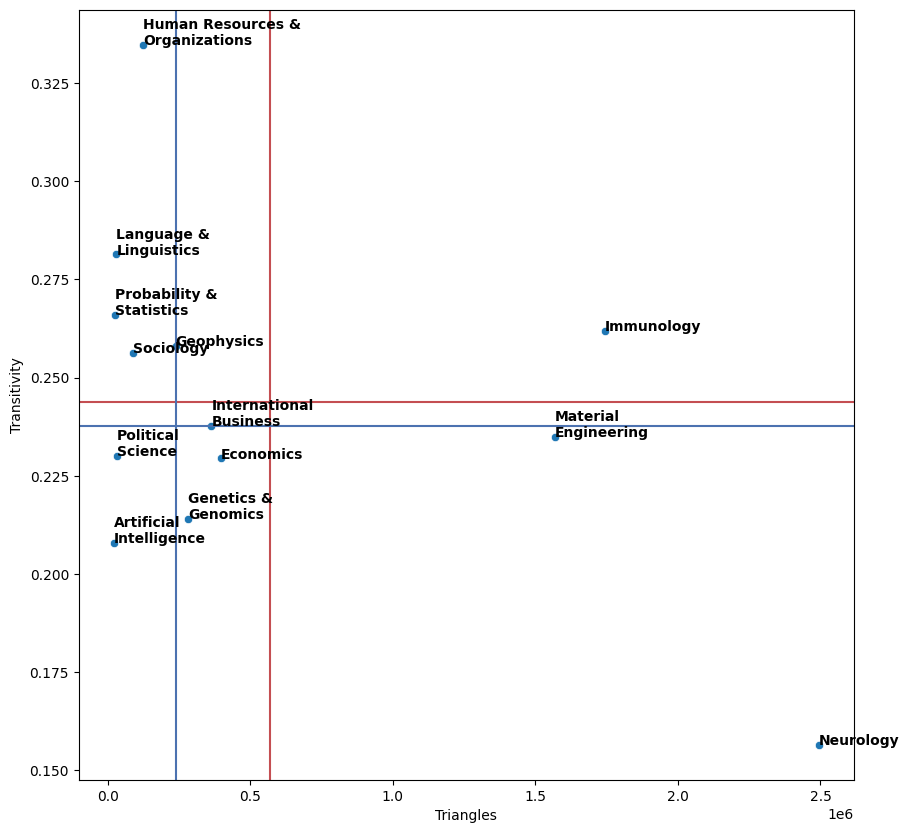

Triangles - Centralization 

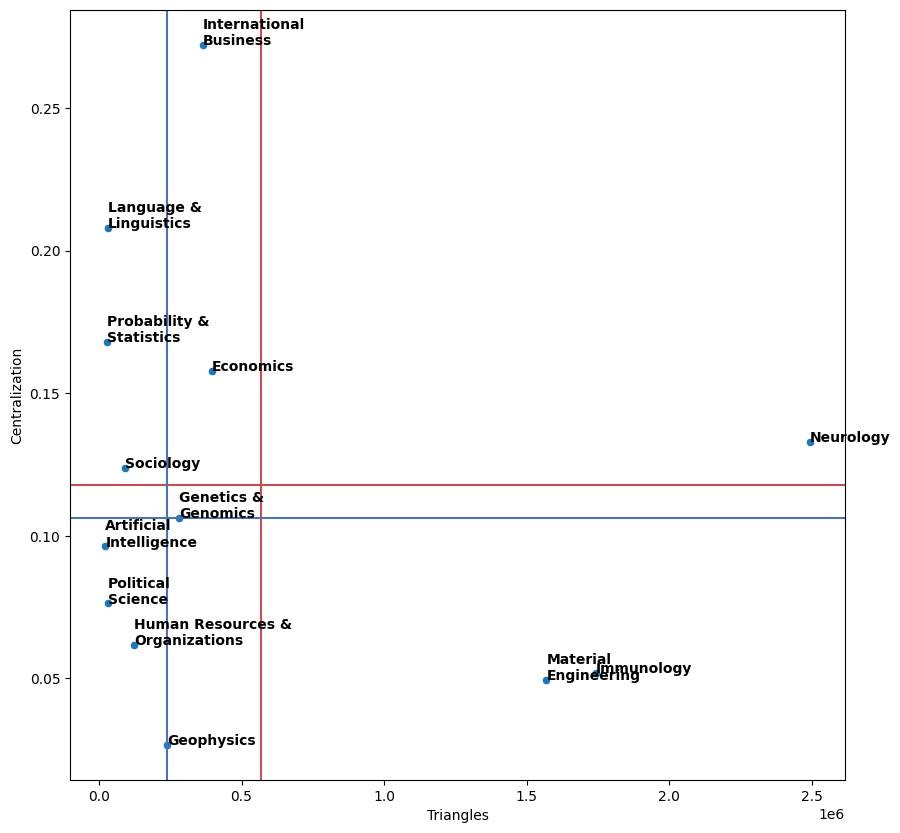

Louvain - Components 

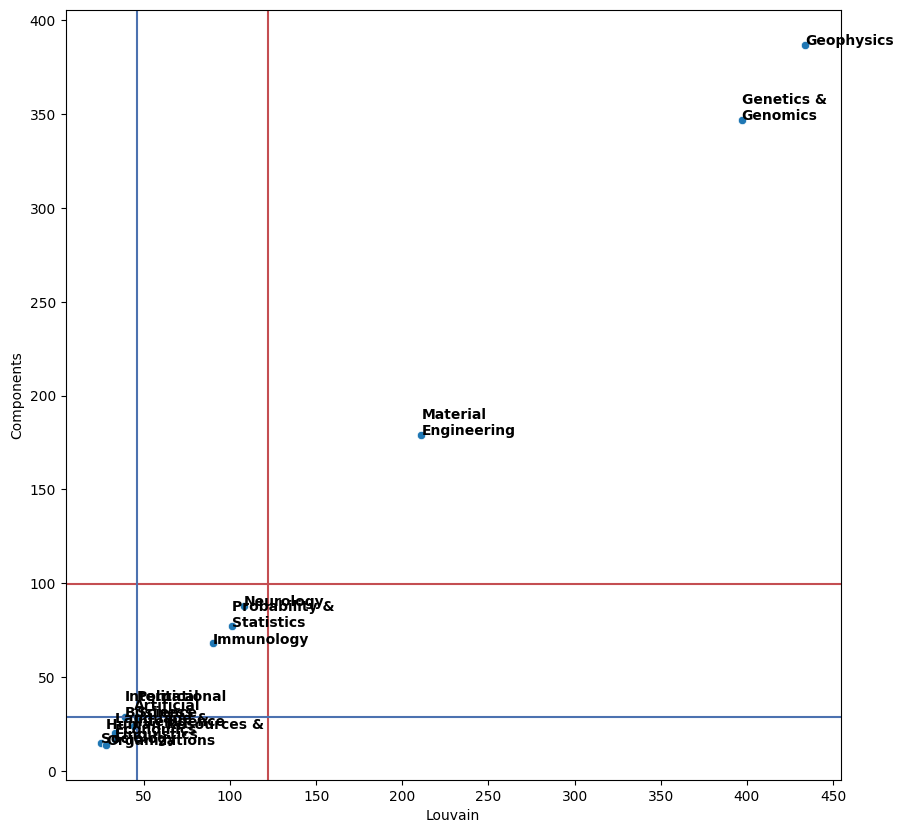

Louvain - AvgClustering 

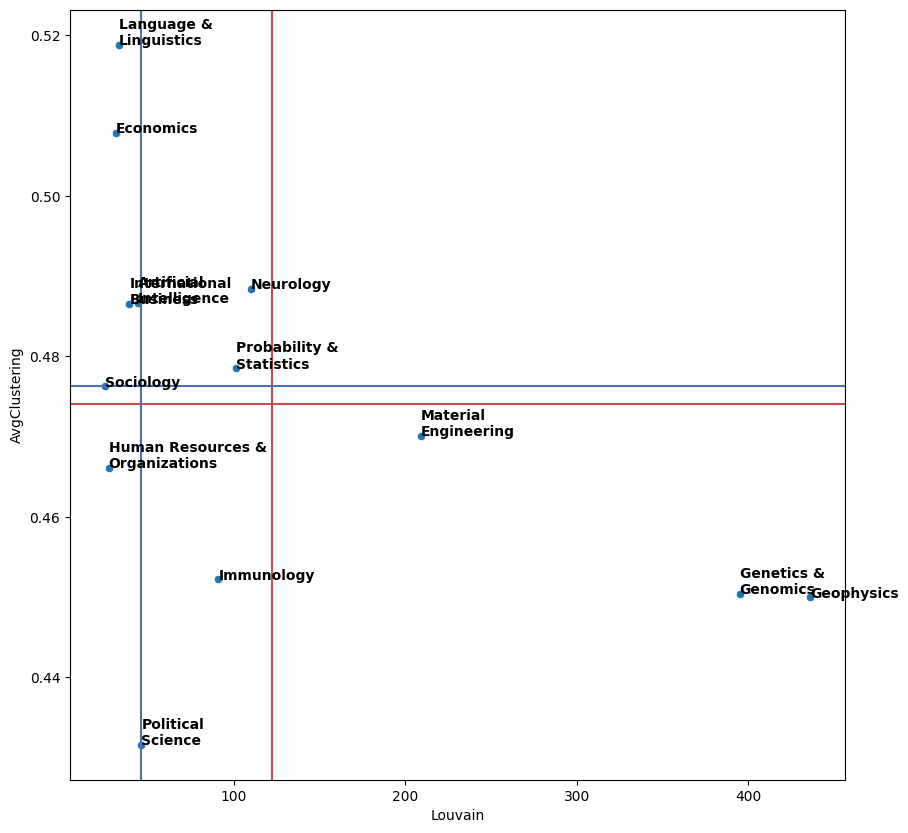

Louvain - Transitivity 

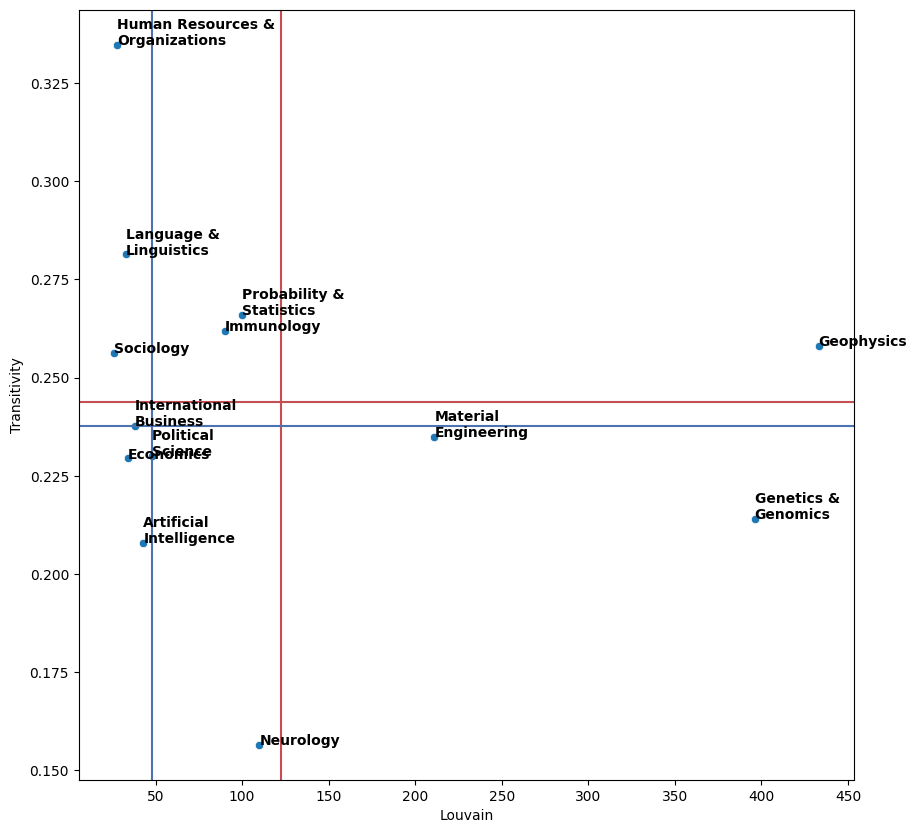

Louvain - Centralization 

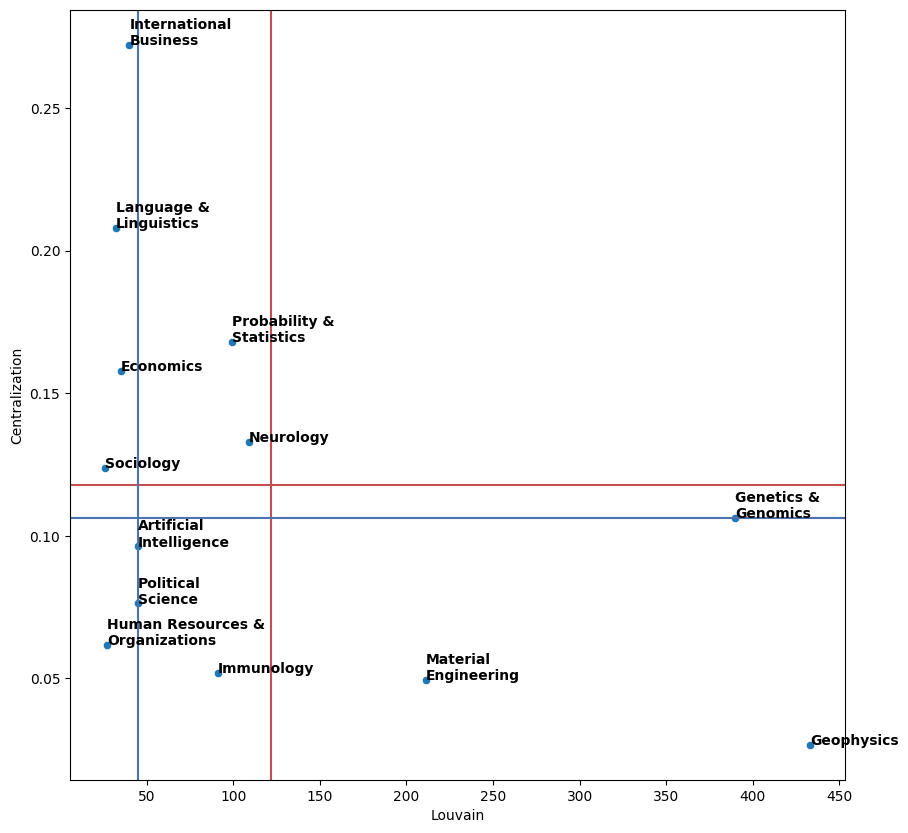

Components - AvgClustering 

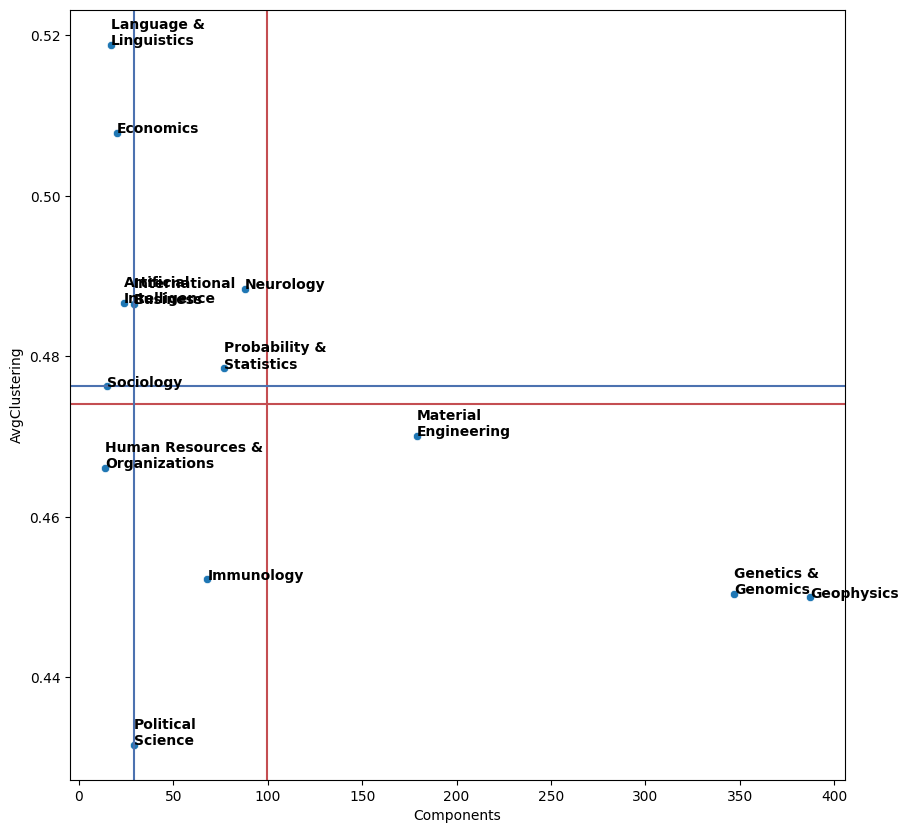

Components - Transitivity 

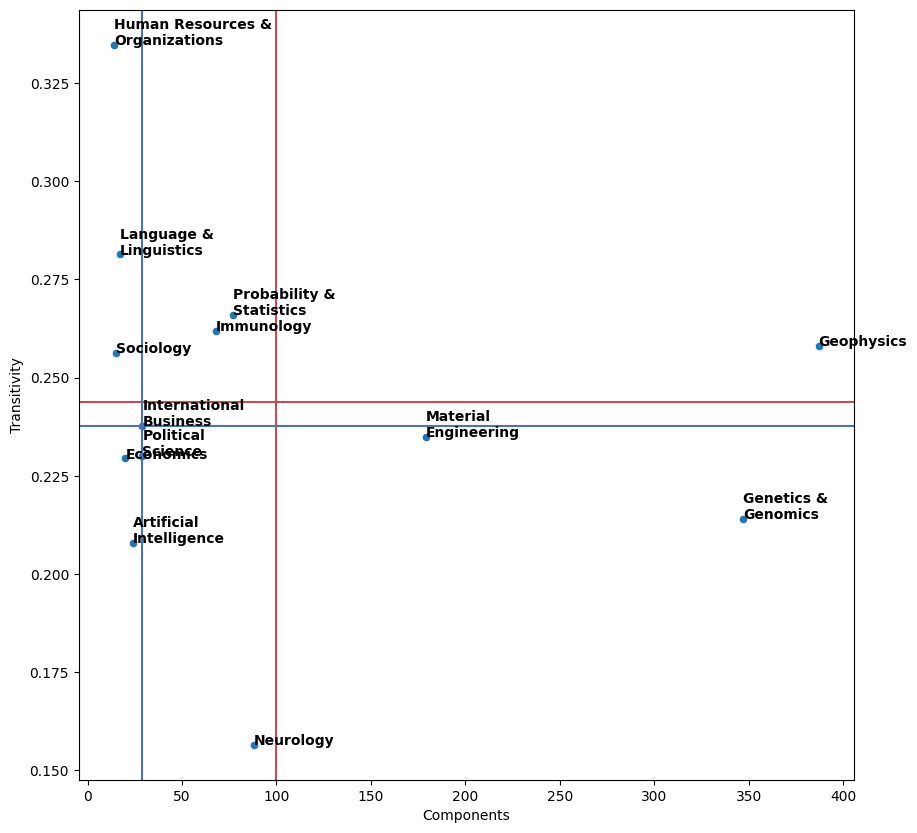

Components - Centralization 

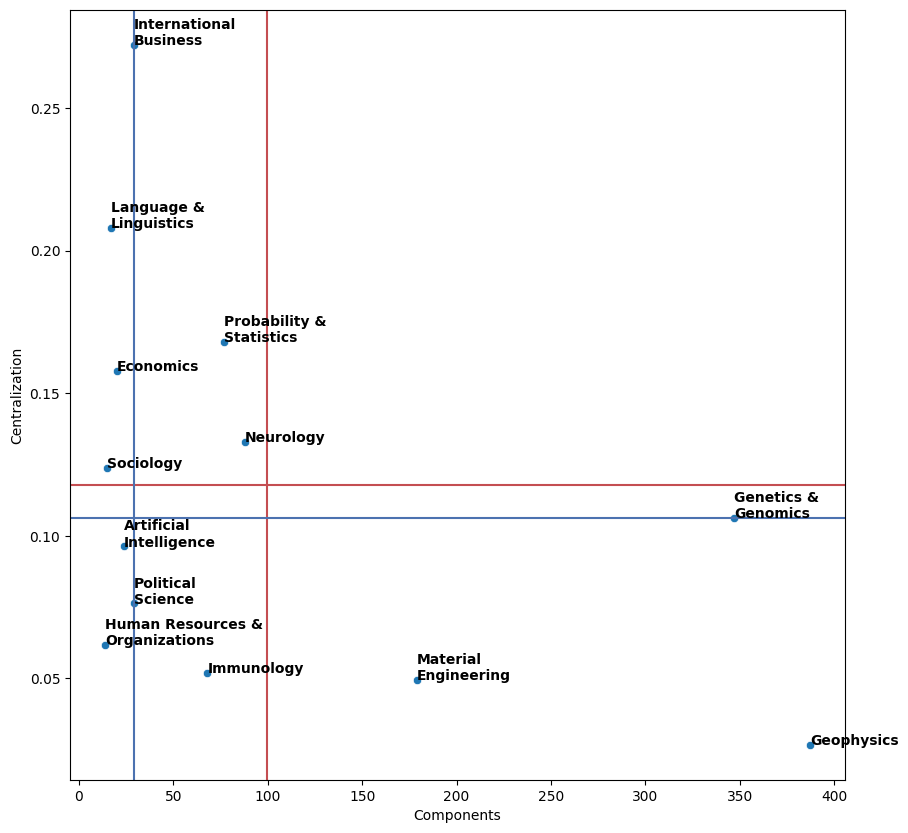

AvgClustering - Transitivity 

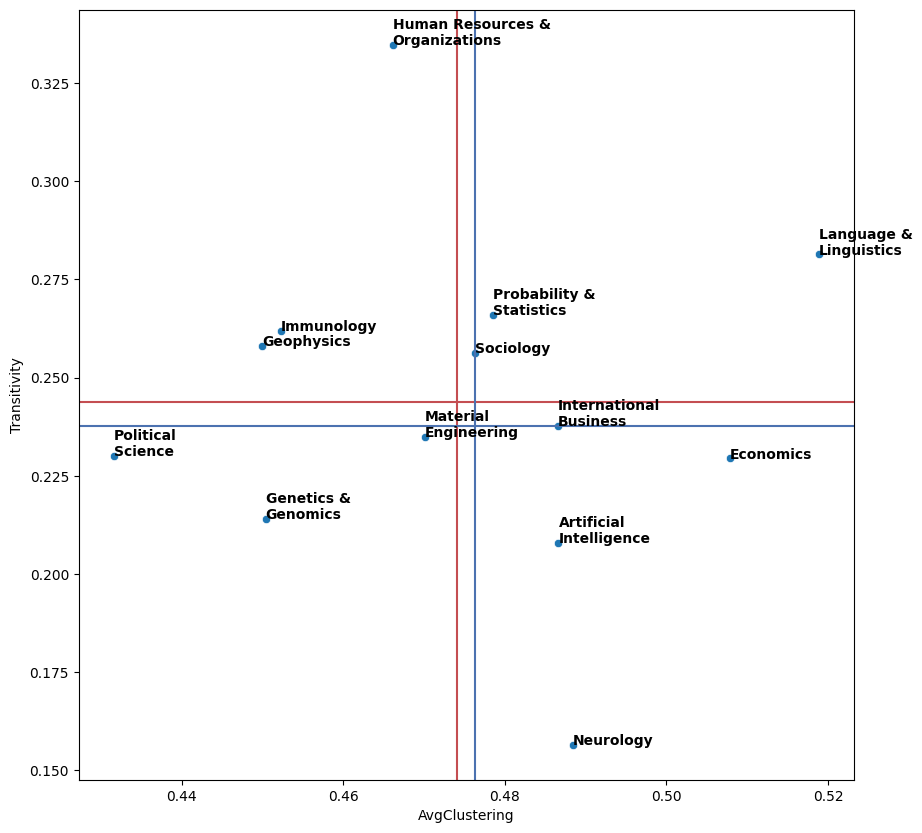

AvgClustering - Centralization 

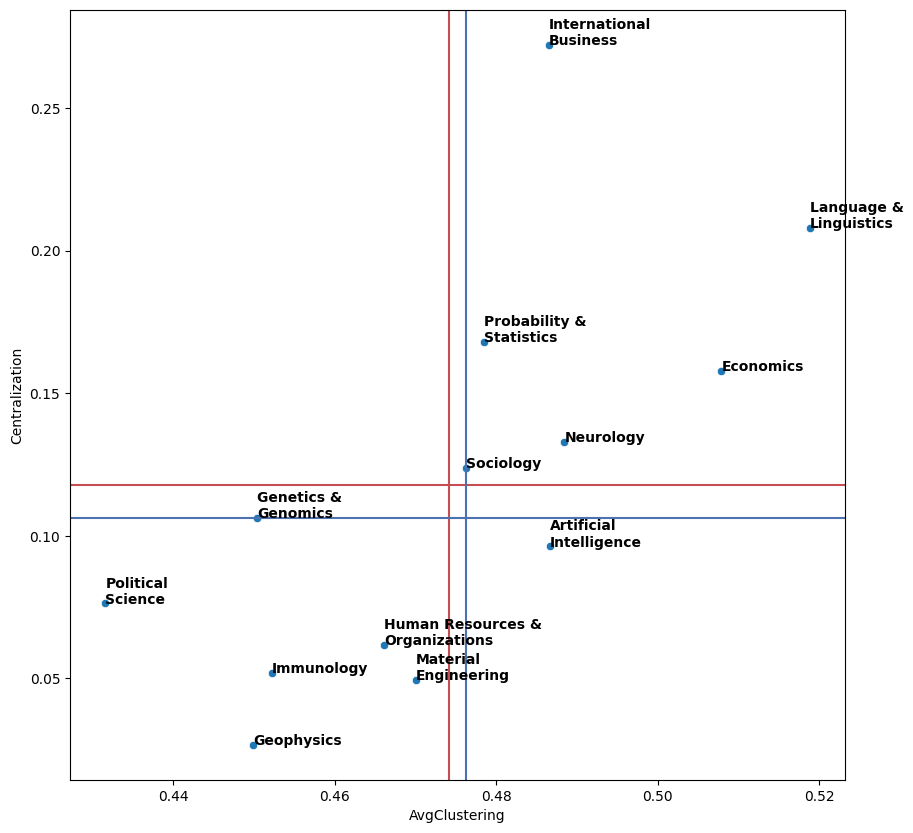

Transitivity - Centralization 

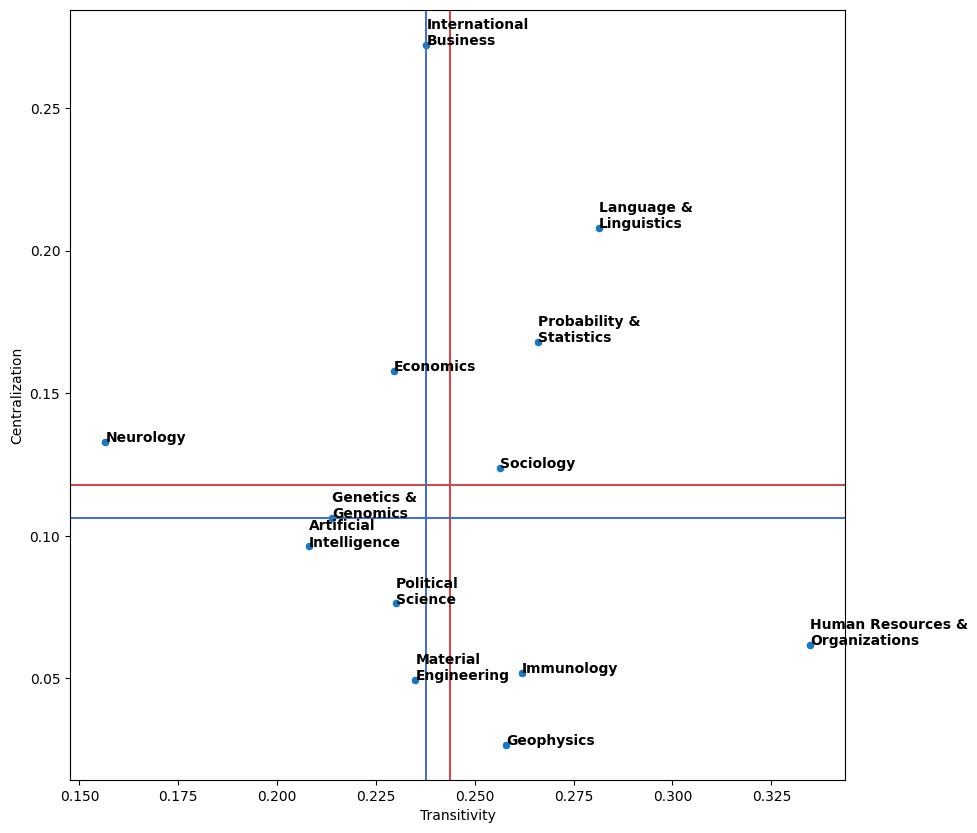

In [164]:
sns.reset_defaults()

for i, (m1, m2) in enumerate(measurment_combs):

    print(f'\r{m1} - {m2}', flush=True, end=' ')

    f1 = measurments[m1]
    f2 = measurments[m2]

    dict1 = {field_name: f1(G) for field_name, G in Gs.items() if field_name not in ['Gender Studies', 'Geometry', 'Ethnic & Cultural Studies']}
    dict2 = {field_name: f2(G) for field_name, G in Gs.items() if field_name not in ['Gender Studies', 'Geometry', 'Ethnic & Cultural Studies']}

    df1 = pl.DataFrame([
        pl.Series('Field', list(dict1.keys()), pl.Utf8),
        pl.Series(m1, list(dict1.values()), pl.Float32),
    ])
    df2 = pl.DataFrame([
        pl.Series('Field', list(dict2.keys()), pl.Utf8),
        pl.Series(m2, list(dict2.values()), pl.Float32),
    ])

    df = df1.join(df2, on='Field')

    x_mean, y_mean, x_median, y_median = df.select(
        pl.col(m1).mean().alias('x_mean'),
        pl.col(m2).mean().alias('y_mean'),
        pl.col(m1).median().alias('x_median'),
        pl.col(m2).median().alias('y_median'),
    ).row(0)

    plt.figure(figsize=(10,10))
    sns.scatterplot(data=df, x=m1, y=m2)

    plt.axhline(y=y_mean, c='r') 
    plt.axvline(x=x_mean, c='r') 

    plt.axhline(y=y_median, c='b') 
    plt.axvline(x=x_median, c='b') 

    for field_name, x, y in df.rows():
        field_name = format_field_name(field_name)
        plt.text(x, y, field_name, horizontalalignment='left', size='medium', color='black', weight='semibold')

    plt.savefig(
        os.path.join(LATEX_FIGURES_PATH, 'all_bivariate', f'{m1}_{m2}.png'),
        transparent=True, 
        dpi=150,
        bbox_inches='tight'
    )

    plt.show()